# Sentiment Analysis of Tweets in Canada

Twitter v.2 API only allows to retrieve conversations from Twitter for the last 7 days. Therefore we looked at Canada 5,000 most recent tweets to know the overall conversation and analyze the overall sentiment.

## Accesing Twitter data using "Tweepy" package

"Tweepy" python package allows to get tweets by query search or place, and language from a given date. This functionality allows to seach tweets in Canada and its provinces and terrioties during the covid-19 pandemic to know and asses the conversation happening in Twitter.

In [28]:
# Keys (a Twitter Developer Account is needed)
consumer_key= 'XXX'
consumer_secret= 'XXX'
access_token= 'XXX-XXX'
access_token_secret= 'XXX'

In [29]:
# Twitter Authentication 
import tweepy as tw

auth = tw.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tw.API(auth, wait_on_rate_limit=True)

In [30]:
# Filtering for tweets in Canada
places = api.geo_search(query='Canada', granularity='country')
place_id = places[0].id

In [31]:
# Search terms
num_of_tweets = int(input ('Please enter the number of tweets to analyze: '))
begin_date = (input ('Please enter the start date for the analysis (it can only go back one week) (YYYY-MM-DD): '))

Please enter the number of tweets to analyze:  20000
Please enter the start date for the analysis (it can only go back one week) (YYYY-MM-DD):  2020-01-01


In [32]:
# Getting tweets and details
tweets = tw.Cursor(api.search, q='place:%s' % place_id, lang='en', since_id=begin_date).items(num_of_tweets)
tweets_details = [[tweet.text, tweet.user.screen_name, tweet.created_at, tweet.retweets, tweet.user.location] for tweet in tweets]

In [33]:
# Converting to dataframe for analysis
import pandas as pd

tweets_details_df = pd.DataFrame(tweets_details, columns=['text', 'user', 'date', 'retweet', 'location'])
tweets_details_df['date'] = tweets_details_df['date'].dt.strftime("%m/%d/%y")
tweets_details_df.head(3)

text             user  \
0  @joeyBADASS 1999 mixtape will forever be a cla...  NOMIKEFINDLAY22   
1  @RM_Transit Anti-Green Line advocates are call...  rustableprawn37   
2  Updated location east side of Rec centre along...   Happyfishtruck   

       date                                            retweet location  
0  06/13/21  <bound method Status.retweets of Status(_api=<...           
1  06/13/21  <bound method Status.retweets of Status(_api=<...  Canada   
2  06/13/21  <bound method Status.retweets of Status(_api=<...

In [34]:
tweets_details_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8118 entries, 0 to 8117
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   text      8118 non-null   object
 1   user      8118 non-null   object
 2   date      8118 non-null   object
 3   retweet   8118 non-null   object
 4   location  8118 non-null   object
dtypes: object(5)
memory usage: 317.2+ KB


In [35]:
tweets_details_df.date.value_counts()

06/13/21    8118
Name: date, dtype: int64

In [36]:
tweets_details_df.location.value_counts()

                                  890
Toronto, Ontario                  672
Canada                            353
Toronto                           288
Ontario, Canada                   180
                                 ... 
Lethbridge , AB                     1
Sarnia Ontario                      1
Avonmore, Ontario, Canada           1
Unceded Musqueam Territory          1
Charlottetown, Prince Edward I      1
Name: location, Length: 1332, dtype: int64

**We found 434 tweets from June 3rd to June 11th, 2021. ~300 tweets might have useful location information**

## Pre-processing Tweets

To analyze tweets we clean the texts to make them machine readable to our model.

In [37]:
# Removing urls and usernames from tweets
import re

def remove_username(text):
    return re.sub('@[^\s]+','', text)

def remove_urls(text):
    return re.sub(r'http\S+','', text)

In [38]:
# Stop words (standard english stop words from the NLTK(Natural Language ToolKit) library, punctuation from the string library, and integers)
import string
from nltk.corpus import stopwords

stop_words = stopwords.words('english')
stop_words += list(string.punctuation)
stop_words += ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'rt', 'rts', 'retweet']

In [39]:
# Tokenizing (splitting words by whitespace with NLTK’s word_tokenize() method)
from nltk.tokenize import word_tokenize

def process_text(text):
    tokens = word_tokenize(text)
    stopwords_removed = [token.lower() for token in tokens if token.lower() not in stop_words]
    return stopwords_removed

In [40]:
# Removing numbers from analysis
def remove_nums(text_object):
    no_nums = list(filter(lambda x: x.isalpha(), text_object))
    return no_nums

In [41]:
# Lemmatizing (breaking a word token down to its root meaning)
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()
def lemmatize_text(df_text):
    lemmatized =[]
    for w in df_text:
        lemmatized.append(lemmatizer.lemmatize(w))
    return lemmatized

In [42]:
# Applying cleaning
tweets_details_df['clean'] = tweets_details_df['text'].apply(
    remove_username).apply(remove_urls).apply(process_text).apply(remove_nums).apply(lemmatize_text)
tweets_details_df.head(3)

text             user  \
0  @joeyBADASS 1999 mixtape will forever be a cla...  NOMIKEFINDLAY22   
1  @RM_Transit Anti-Green Line advocates are call...  rustableprawn37   
2  Updated location east side of Rec centre along...   Happyfishtruck   

       date                                            retweet location  \
0  06/13/21  <bound method Status.retweets of Status(_api=<...            
1  06/13/21  <bound method Status.retweets of Status(_api=<...  Canada    
2  06/13/21  <bound method Status.retweets of Status(_api=<...            

                                               clean  
0                        [mixtape, forever, classic]  
1  [line, advocate, calling, train, strategy, pre...  
2  [updated, location, east, side, rec, centre, a...

In [43]:
# Saving dataframe for future work
tweets_details_df.to_csv('Canada_tweets_June3to10.csv')

## Tweets Sentiment Analysis

For the sentiment classification, we use NaivesBayesAnalyzer which is an NLTK model trained on a movie reviews corpus to classify tweets as having a positive or negative sentiment.

In [44]:
# Tweets Sentiment Classification
from textblob import TextBlob
from textblob.sentiments import NaiveBayesAnalyzer

tweets_text = tweets_details_df['text']
blob = TextBlob(",".join(map(str, tweets_text)), analyzer = NaiveBayesAnalyzer())
tweets_sentiment = pd.DataFrame(columns = ['text', 'nb_polarity', 'nb_subjectivity', 'nb_classification', 'nb_pos_score', 'nb_neg_score'])
for tweet in blob.sentences:
    tweets_sentiment.loc[len(tweets_sentiment)] = [str(tweet), tweet.polarity, tweet.subjectivity, tweet.sentiment.classification, tweet.sentiment.p_pos, tweet.sentiment.p_neg]
    
tweets_sentiment['clean'] = tweets_sentiment['text'].apply(
    remove_username).apply(remove_urls).apply(process_text).apply(remove_nums).apply(lemmatize_text)

We use "TextBlob" package to get sentiments scores on polarity and subjectiviy of tweets. The scores are defined based on semantic relations and the frequency of each word in an input text.
Polarity ranges from -1 to 1 (neggative to positive) and subjectivity from 0 to 1 where 0 is objective.

In [45]:
# Tweets Sentiment Scores
tweets_sentiment['liststring'] = [','.join(map(str, l)) for l in tweets_sentiment['clean']]
tweets_sentiment['liststring'] = tweets_sentiment['liststring'].apply(lambda elem: re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", " ", elem))
blob = [TextBlob(tweet, analyzer = NaiveBayesAnalyzer()) for tweet in tweets_sentiment['liststring']]
tweets_sentiment['tb_polarity'] = [tweet.polarity for tweet in blob]
tweets_sentiment['tb_subjectivity'] = [tweet.subjectivity for tweet in blob]

In [46]:
# Selecting only tweets with scores and calculating average polarity and subjectivity
import warnings
warnings.filterwarnings('ignore')

analyzed_tweets = tweets_sentiment[(tweets_sentiment.tb_subjectivity != 0) & (tweets_sentiment.tb_polarity != 0)]
analyzed_tweets['polarity'] = (analyzed_tweets['nb_polarity'] + analyzed_tweets['tb_polarity']) / 2 
analyzed_tweets['subjectivity'] = (analyzed_tweets['nb_subjectivity'] + analyzed_tweets['tb_subjectivity']) / 2 
di = {'pos': 'Positive', 'neg': 'Negative'}
analyzed_tweets.replace({'nb_classification': di}, inplace=True)
analyzed_tweets.head(3)

text  nb_polarity  \
0  @joeyBADASS 1999 mixtape will forever be a cla...       0.0000   
2  What a beautiful sight 🏳️‍🌈🏳️‍🌈🏳️‍🌈 https://t....       0.1875   
3         Yes they are winning with 10 minutes left.       0.2500   

   nb_subjectivity nb_classification  nb_pos_score  nb_neg_score  \
0            0.000          Positive      0.999832      0.000168   
2            0.500          Negative      0.354129      0.645871   
3            0.375          Negative      0.495387      0.504613   

                                               clean  \
0  [mixtape, forever, classic, line, advocate, ca...   
2  [beautiful, sight, many, whole, scope, thing, ...   
3                       [yes, winning, minute, left]   

                                          liststring  tb_polarity  \
0  mixtape forever classic line advocate calling ...     0.166667   
2  beautiful sight many whole scope thing miniscu...     0.375000   
3                            yes winning minute left     0.250000   

   tb_subjectivity  polarity  subjectivity  
0         0.166667  0.083333      0.083333  
2         0.500000  0.281250      0.500000  
3         0.375000  0.250000      0.375000

In [47]:
analyzed_tweets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3118 entries, 0 to 5039
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   text               3118 non-null   object 
 1   nb_polarity        3118 non-null   float64
 2   nb_subjectivity    3118 non-null   float64
 3   nb_classification  3118 non-null   object 
 4   nb_pos_score       3118 non-null   float64
 5   nb_neg_score       3118 non-null   float64
 6   clean              3118 non-null   object 
 7   liststring         3118 non-null   object 
 8   tb_polarity        3118 non-null   float64
 9   tb_subjectivity    3118 non-null   float64
 10  polarity           3118 non-null   float64
 11  subjectivity       3118 non-null   float64
dtypes: float64(8), object(4)
memory usage: 316.7+ KB


**We were able to classify the sentiment of 146 tweets**

## Sentiment Analysis Visualization

In [48]:
import altair as alt

domain = ['Negative', 'Positive']
range_ = ['red', 'green']

one = alt.Chart(analyzed_tweets).mark_bar().encode(
    y=alt.Y('nb_classification:N', title=None, axis=alt.Axis(labels=False)),
    x=alt.X('count()', title='Number of Tweets'),
    color=alt.Color('nb_classification:N', legend=alt.Legend(orient='top', title='Sentiment Classification'), scale=alt.Scale(domain=domain, range=range_))
).properties(width=850)

two = alt.Chart(analyzed_tweets, title='Polarity Distribution').mark_bar().encode(
    x=alt.X("polarity:Q", bin=True, title=None, scale=alt.Scale(domain=[-1, 1])),
    y=alt.Y('count()', title='Number of Tweets'),
).properties(height=200)

three = alt.Chart(analyzed_tweets, title='Subjectivity Distribution').mark_bar().encode(
    x=alt.X("subjectivity:Q", bin=True, title=None, scale=alt.Scale(domain=[0, 1])),
    y=alt.Y('count()', title='Number of Tweets'),
).properties(height=200)

four = alt.Chart(analyzed_tweets[analyzed_tweets['nb_classification']=='Positive'], title='Positive Scores Distribution').mark_bar(color='green').encode(
    x=alt.X("nb_pos_score:Q", bin=True, title=None, scale=alt.Scale(domain=[.5, 1])),
    y=alt.Y('count()', title='Number of Tweets'),
).properties(height=200)

five = alt.Chart(analyzed_tweets[analyzed_tweets['nb_classification']=='Negative'], title='Negative Scores Distribution').mark_bar(color='red').encode(
    x=alt.X("nb_neg_score:Q", bin=True, title=None, scale=alt.Scale(domain=[.5, 1])),
    y=alt.Y('count()', title='Number of Tweets'),
).properties(height=200)

sentiment_dash = one & (four | five) & (two | three)

In [49]:
sentiment_dash

alt.VConcatChart(...)

**The majority of analized tweets are classified as having a positive sentiment.\
Postive classified tweets are more positive than negative classified tweets are negative.\
Tweets analyzed are more likely to express a subjective opinion and have a positive polarity.**

## Word Cloud Visualization

A word cloud is an image composed of words, in which the size of each word indicates its frequency in a text. This visualiaztion allows us to know the most frequent words used in this topic.

In [50]:
# Search terms
num_of_words = int(input ('Please enter the number of word to analyze: '))

Please enter the number of word to analyze:  50


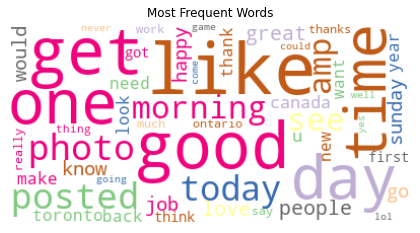

In [51]:
# Visualizing the top 'num_of_words' (by frequency)
from nltk import FreqDist
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

flat_words = [item for sublist in tweets_details_df['clean'] for item in sublist]
word_freq = FreqDist(flat_words)
most_common_count = [x[1] for x in word_freq.most_common(num_of_words)]
most_common_word = [x[0] for x in word_freq.most_common(num_of_words)]
top_dictionary = dict(zip(most_common_word, most_common_count))

wordcloud = WordCloud(colormap = 'Accent', background_color = 'white').generate_from_frequencies(
    top_dictionary)
plt.figure(facecolor = None)
plt.title('Most Frequent Words')
plt.imshow(wordcloud, interpolation='bilinear')
plt.tight_layout(pad=0)
plt.axis("off")
plt.show()

**The above visualization shows the most frequent words in our retrieved Tweets**

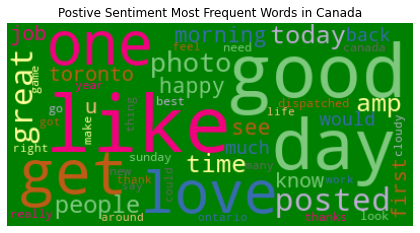

In [52]:
# Visualizing the top 'num_of_words' (by frequency) associated with positive sentiment
flat_words = [item for sublist in analyzed_tweets[analyzed_tweets['nb_classification']=='Positive'].clean for item in sublist]
word_freq = FreqDist(flat_words)
most_common_count = [x[1] for x in word_freq.most_common(num_of_words)]
most_common_word = [x[0] for x in word_freq.most_common(num_of_words)]
top_dictionary = dict(zip(most_common_word, most_common_count))

wordcloud = WordCloud(colormap = 'Accent', background_color = 'green').generate_from_frequencies(
    top_dictionary)
plt.figure(facecolor = None)
plt.title('Postive Sentiment Most Frequent Words in Canada')
plt.imshow(wordcloud, interpolation='bilinear')
plt.tight_layout(pad=0)
plt.axis("off")
plt.show()

**The above visualization shows the most frequent words associated with positive sentiment Tweets**

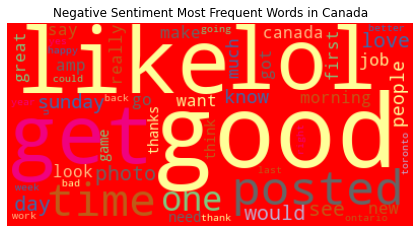

In [53]:
# Visualizing the top 'num_of_words' (by frequency) associated with positive sentiment
flat_words = [item for sublist in analyzed_tweets[analyzed_tweets['nb_classification']=='Negative'].clean for item in sublist]
word_freq = FreqDist(flat_words)
most_common_count = [x[1] for x in word_freq.most_common(num_of_words)]
most_common_word = [x[0] for x in word_freq.most_common(num_of_words)]
top_dictionary = dict(zip(most_common_word, most_common_count))

wordcloud = WordCloud(colormap = 'Accent', background_color = 'red').generate_from_frequencies(
    top_dictionary)
plt.figure(facecolor = None)
plt.title('Negative Sentiment Most Frequent Words in Canada')
plt.imshow(wordcloud, interpolation='bilinear')
plt.tight_layout(pad=0)
plt.axis("off")
plt.show()

**The above visualization shows the most frequent words associated with negative sentiment Tweets**

## Future Work

We could segment the tweets using its location to asses the sentiment by province/territory.\
We could group the tweets by date to analyze the sentiment evolution over a time period.\
We could cluster texts by topic (e.g. economy, life-style, politics, etc) and asses the overall sentiment.\

# Limitations

Twitter Standard v.2 API allows to retrieve only 450 tweet requests per 15 minute window and retrieved up to 500,000 tweets by month. The tweets retireved can only be up to 7 days old.\
Tweepy Cursor method retrieves tweets from the most current date back to the initial date and fills the total number of tweets that way, therefore, retrieving a small number of tweets will likely only show results from the most recent dates.
Tweepy only allows to seach tweets by place or keyword but not both (as far as my research has gone).